In [1]:
with open('./share/common.py') as fin:
   exec(fin.read())

In [2]:
with open('./share/matplotlibconf.py') as fin:
    exec(fin.read())

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import joblib

In [4]:
df = pd.read_csv("./data/winemag-data_first150k.csv")

In [5]:
df_parsed = df[df.duplicated('description', keep=False)]
df_parsed.dropna(subset=['description', 'points'])

,Unnamed: 0,country,description,designation,...,region_1,region_2,variety,winery
25,25,New Zealand,"Yields were down in 2015, ...",Maté's Vineyard,...,NaN,NaN,Chardonnay,Kumeu River
29,29,US,This standout Rocks Distri...,The Funk Estate,...,Walla Walla Valley (WA),Columbia Valley,Syrah,Saviah
60,60,Argentina,"Concentrated, ripe blackbe...",The Apple Doesn't Fall Far...,...,Mendoza,NaN,Malbec,Matias Riccitelli
61,61,Australia,Moorooduc's estate Pinot N...,NaN,...,Mornington Peninsula,NaN,Pinot Noir,Moorooduc
62,62,Argentina,Smoky aromas of fresh-cut ...,Alegoría Gran Reserva,...,Mendoza,NaN,Malbec,Navarro Correas
...,...,...,...,...,...,...,...,...,...
150925,150925,Italy,Many people feel Fiano rep...,NaN,...,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,150926,France,Offers an intriguing nose ...,Cuvée Prestige,...,Champagne,NaN,Champagne Blend,H.Germain
150927,150927,Italy,This classic example comes...,Terre di Dora,...,Fiano di Avellino,NaN,White Blend,Terredora
150928,150928,France,"A perfect salmon shade, wi...",Grand Brut Rosé,...,Champagne,NaN,Champagne Blend,Gosset


In [6]:
df_parsed.iloc[2,:]['description']

'Concentrated, ripe blackberry and cassis aromas come with peppery spice and cedary oak notes. This is big and generous on the palate, with roasted, well-oaked blackberry flavors. A touch of heat lends sizzle to the finish. Drink through 2020.'

In [7]:
dp = df_parsed[['description', 'points']]
dp.head()

,description,points
25,"Yields were down in 2015, ...",94
29,This standout Rocks Distri...,94
60,"Concentrated, ripe blackbe...",91
61,Moorooduc's estate Pinot N...,91
62,Smoky aromas of fresh-cut ...,91


In [8]:
dp.groupby(['points']).count()['description']

points
80      581
81      962
82     2671
83     3934
84     6689
       ... 
96      426
97      234
98       89
99       34
100      22
Name: description, Length: 21, dtype: int64

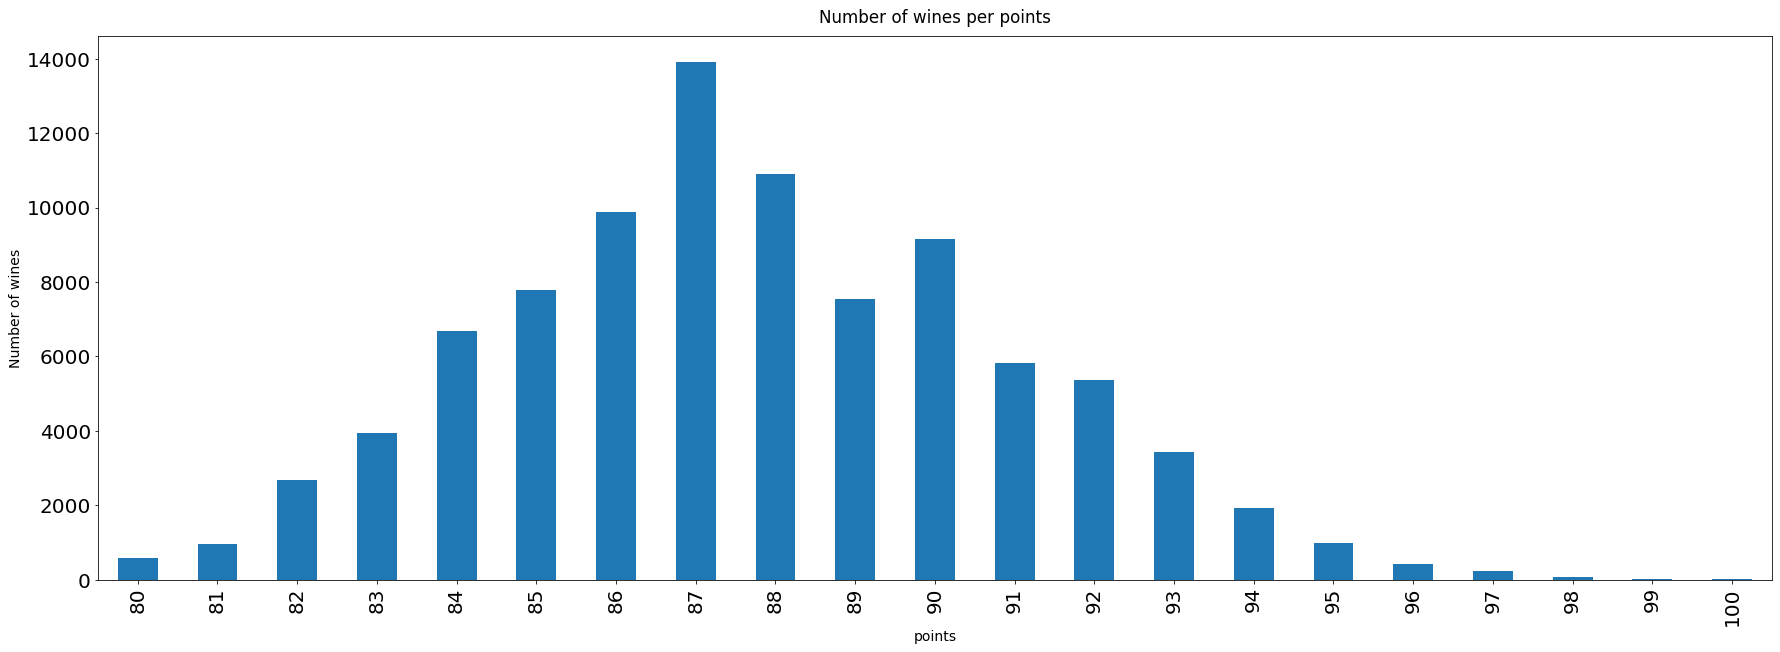

In [9]:
fig, ax = plt.subplots(figsize=(30,10))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title('Number of wines per points')
ax.set_xlabel('Points')
ax.set_ylabel('Number of wines')
dp.groupby(['points']).count()['description'].plot(ax=ax, kind='bar')

### Description length vs points

In [10]:
dp = dp.assign(description_len = dp['description'].apply(len))
dp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92393 entries, 25 to 150929
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   description      92393 non-null  object
 1   points           92393 non-null  int64 
 2   description_len  92393 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.8+ MB


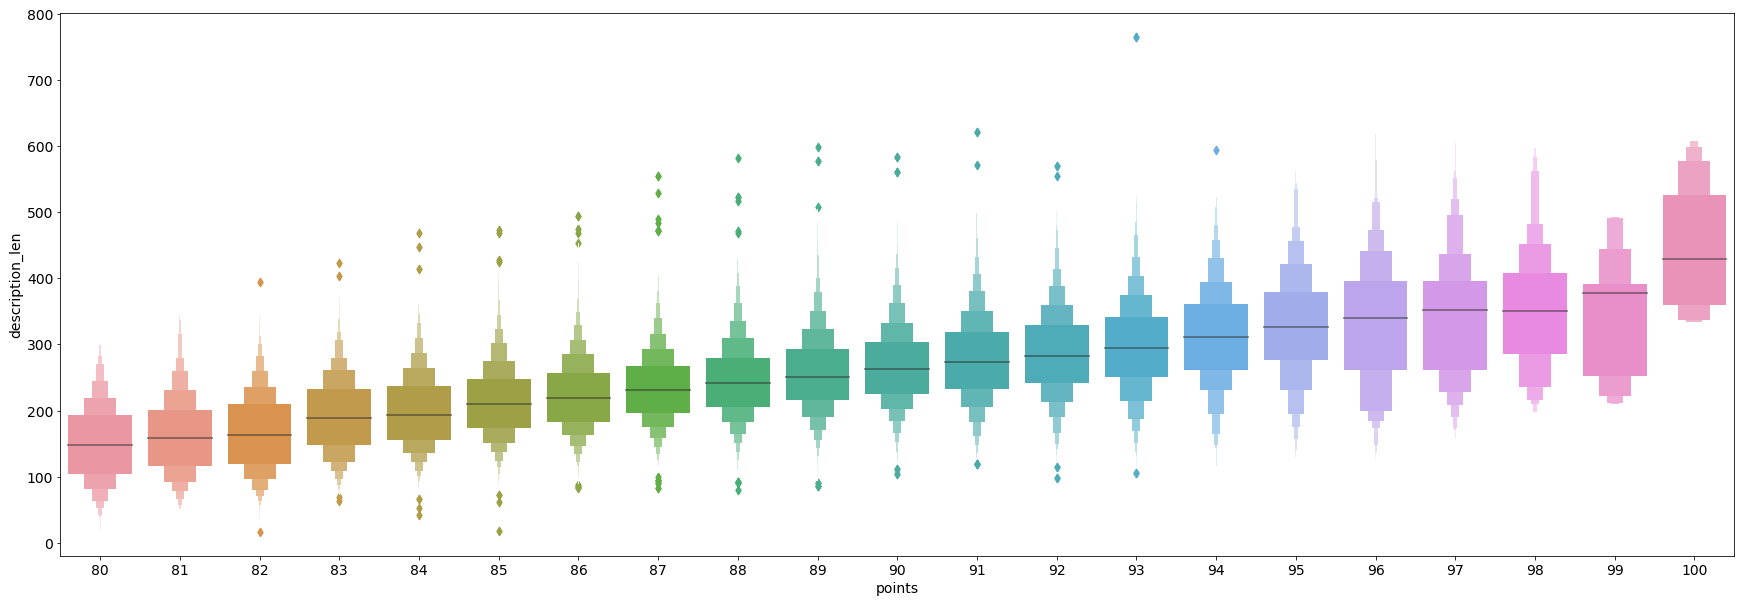

In [11]:
fig, ax = plt.subplots(figsize=(30,10))
sns.boxenplot(x='points', y='description_len', data=dp)

In [12]:
#Transform method taking points as param
def transform_points_simplified(points):
    if points < 84:
        return 1
    elif points >= 84 and points < 88:
        return 2 
    elif points >= 88 and points < 92:
        return 3 
    elif points >= 92 and points < 96:
        return 4 
    else:
        return 5

In [13]:
dp = dp.assign(points_simplified = dp['points'].apply(transform_points_simplified))
dp.head()

,description,points,description_len,points_simplified
25,"Yields were down in 2015, ...",94,215,4
29,This standout Rocks Distri...,94,333,4
60,"Concentrated, ripe blackbe...",91,242,3
61,Moorooduc's estate Pinot N...,91,315,3
62,Smoky aromas of fresh-cut ...,91,229,3


In [14]:
X = dp['description']
y = dp['points_simplified']

In [15]:
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)

In [16]:
X.shape

(92393, 21400)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)
model = RandomForestClassifier()
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [18]:
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

precision    recall  f1-score   support

           1       1.00      0.94      0.97       763
           2       0.97      0.99      0.98      3830
           3       0.97      0.98      0.98      3418
           4       1.00      0.95      0.98      1135
           5       1.00      0.96      0.98        94

    accuracy                           0.98      9240
   macro avg       0.99      0.97      0.98      9240
weighted avg       0.98      0.98      0.98      9240



In [19]:
joblib.dump(model, "./models/model.pkl", compress=3)

['./models/model.pkl']

In [20]:
joblib.dump(vectorizer, "./models/vectorizer.pkl", compress=3)

['./models/vectorizer.pkl']

In [21]:
rfc_model = joblib.load("./models/model.pkl")

In [22]:
vectorizer = joblib.load("./models/vectorizer.pkl")

In [23]:
predictions = rfc_model.predict(X_test)

In [24]:
print(classification_report(y_test, predictions))

precision    recall  f1-score   support

           1       1.00      0.94      0.97       763
           2       0.97      0.99      0.98      3830
           3       0.97      0.98      0.98      3418
           4       1.00      0.95      0.98      1135
           5       1.00      0.96      0.98        94

    accuracy                           0.98      9240
   macro avg       0.99      0.97      0.98      9240
weighted avg       0.98      0.98      0.98      9240



In [25]:
story = ['Aromas include tropical fruit, broom, brimstone and dried herb. The palate is not overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.']

In [26]:
story = vectorizer.transform(story)

In [27]:
story.shape

(1, 21400)

In [28]:
prediction = rfc_model.predict(story)

In [29]:
prediction[0]

2